# 9. Evaluate the Hybrid Restoration Pipeline

This notebook evaluates and compares the performance of three different image restoration methods:
1.  **Real-ESRGAN Only**: The baseline model for detail enhancement.
2.  **U-Net Only**: The PyTorch model trained for color and light correction.
3.  **Hybrid Pipeline (U-Net + Real-ESRGAN)**: The 2-step pipeline that first corrects color/light with the U-Net and then enhances details with Real-ESRGAN.

We will process a set of test images and compare the outputs both visually and quantitatively using PSNR and SSIM metrics against the ground truth.

### 1. Setup and Imports

Import all necessary libraries, define file paths, and set up the device (GPU/CPU).

In [ ]:
import torch
import numpy as np
from PIL import Image
import os
import cv2
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Make sure the project root is in the Python path
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..')))

from src.dl.hybrid_pipeline import HybridPipeline
from src.dl.realesrgan_wrapper import RealESRGANWrapper
from src.dl.pytorch_unet import UNet
from torchvision import transforms

# --- Configuration ---
UNET_MODEL_PATH = "../outputs/models/unet/best_unet_resnet34_perceptual.pth"
REALESRGAN_MODEL_STR = "x4"
TEST_IMAGE_DIR = "../data/raw/AI_for_Art_Restoration_2/paired_dataset_art/damaged"
GROUND_TRUTH_DIR = "../data/raw/AI_for_Art_Restoration_2/paired_dataset_art/undamaged"
OUTPUT_DIR = "../outputs/evaluation_hybrid"

# Select a few images for testing
TEST_IMAGES = ["1.png"]

# --- Setup ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check if U-Net model exists
if not os.path.exists(UNET_MODEL_PATH):
    print(f"ERROR: U-Net model not found at {UNET_MODEL_PATH}")
    print("Please train the U-Net model first by running 'src/training/train_unet.py'")
else:
    print("U-Net model found.")


### 2. Load Models

Instantiate all three models:
- The standalone `RealESRGANWrapper`.
- The standalone `UNet`.
- The combined `HybridPipeline`.

In [2]:

%pip install segmentation-models-pytorch -q
import segmentation_models_pytorch as smp
import gc

# --- Clear CUDA cache ---
torch.cuda.empty_cache()
gc.collect()

# --- Load the full Hybrid Pipeline ---
# This single object contains the U-Net, Real-ESRGAN, and GFPGAN models.
# We will access the individual models through this object to avoid loading redundant copies into memory.
hybrid_pipeline = None
if os.path.exists(UNET_MODEL_PATH):
    try:
        hybrid_pipeline = HybridPipeline(UNET_MODEL_PATH, REALESRGAN_MODEL_STR, device)
        print("Hybrid pipeline loaded successfully.")
        print("Contained models (U-Net, Real-ESRGAN, GFPGAN) are now in memory.")
    except Exception as e:
        print(f"Error loading the hybrid pipeline: {e}")
else:
    print(f"U-Net model not found at {UNET_MODEL_PATH}, cannot load the pipeline.")


# Transformation for U-Net input
unet_transform = transforms.Compose([
    transforms.ToTensor(),
])


Note: you may need to restart the kernel to use updated packages.
HybridPipeline using device: cuda
Loading U-Net model from ../outputs/models/unet/best_unet_resnet34_perceptual.pth...
U-Net model loaded successfully.
Loading Real-ESRGAN model 'x4'...
Loaded Real-ESRGAN: RealESRGAN_x4plus | scale=4 | device=cuda
Real-ESRGAN model loaded successfully.
Loading GFPGAN for face enhancement...


d:\R&D Project\image_processing\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\R&D Project\image_processing\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


GFPGAN model loaded successfully.
Hybrid pipeline loaded successfully.
Contained models (U-Net, Real-ESRGAN, GFPGAN) are now in memory.


### 3. Define Helper and Metric Functions

Create helper functions to:
- Run each restoration model on an image.
- Calculate PSNR and SSIM between two images.
- Display the results in a grid.

In [3]:

def restore_realesrgan_only(img_bgr):
    """Restores an image using only Real-ESRGAN from the pipeline."""
    if hybrid_pipeline is None: return None
    # Access the realesrgan model *within* the pipeline object and add tiling
    restored_img_bgr, _ = hybrid_pipeline.realesrgan.restore(img_bgr)
    return cv2.cvtColor(restored_img_bgr, cv2.COLOR_BGR2RGB)

def restore_unet_only(img_pil):
    """Restores an image using only the U-Net model from the pipeline.

    Important: de-normalize the model output if the model was trained to
    produce outputs in the [-1, 1] range. We convert to [0,1], clamp and
    then convert to a PIL image.
    """
    if hybrid_pipeline is None: return None

    with torch.no_grad():
        # Prepare input tensor (make sure this matches training preprocessing)
        input_tensor = unet_transform(img_pil).unsqueeze(0).to(device)
        output_tensor = hybrid_pipeline.unet(input_tensor)

    # If the model was trained to output values in [-1, 1], de-normalize to [0, 1].
    # If your model outputs [0,1] already, this will still be safe (it will map
    # 0->0.5 etc.), so confirm training preprocessing. The formula below assumes
    # the model's output range is [-1, 1].
    try:
        out = (output_tensor * 0.5) + 0.5
        out = torch.clamp(out, 0.0, 1.0)
    except Exception:
        out = output_tensor

    # Convert tensor to PIL Image
    output_img = transforms.ToPILImage()(out.squeeze(0).cpu())
    return np.array(output_img)


def restore_gfpgan_only(img_bgr):
    """Restores an image using only GFPGAN from the pipeline."""
    if hybrid_pipeline is None: return None
    # Access the gfpgan model *within* the pipeline object
    _, _, restored_img_bgr = hybrid_pipeline.gfpgan.enhance(
        img_bgr, has_aligned=False, only_center_face=False, paste_back=True
    )
    return cv2.cvtColor(restored_img_bgr, cv2.COLOR_BGR2RGB)


def restore_hybrid(img_pil, img_name):
    """Restores an image using the full 3-step hybrid pipeline."""
    if hybrid_pipeline is None: return None

    # The full pipeline logic is already in the object's method.
    # We just need to call it. It returns a PIL image.
    restored_pil = hybrid_pipeline.restore_image(img_pil, output_dir=OUTPUT_DIR, img_name=img_name)
    return np.array(restored_pil)


def calculate_metrics(img1, img2):
    """Calculates PSNR and SSIM between two images."""
    # Convert PIL images to numpy arrays if they are not already
    if isinstance(img1, Image.Image):
        img1 = np.array(img1)
    if isinstance(img2, Image.Image):
        img2 = np.array(img2)

    # Resize images to match if they have different dimensions
    if img1.shape != img2.shape:
        h, w, _ = img1.shape
        img2 = cv2.resize(img2, (w, h))

    psnr_val = psnr(img1, img2, data_range=255)
    ssim_val = ssim(img1, img2, data_range=255, multichannel=True, channel_axis=2)
    return psnr_val, ssim_val

def plot_results(images, titles, figsize=(20, 10)):
    """Displays a grid of images with their titles."""
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### 4. Run Evaluation Loop

Iterate through the test images, apply each restoration method, calculate metrics, and display the results.

In [4]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_summary())
print(torch.cuda.empty_cache())
print(torch.cuda.memory_allocated())

682052608
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 666067 KiB | 666067 KiB |    808 MiB | 162135 KiB |
|       from large pool | 562944 KiB | 562944 KiB |    637 MiB |  89344 KiB |
|       from small pool | 103123 KiB | 103123 KiB |    171 MiB |  72791 KiB |
|---------------------------------------------------------------------------|
| Active memory         | 666067 KiB | 666067 KiB |    808 MiB | 162135 KiB |
|       from large pool | 562944 KiB | 562944 KiB |   

--- Processing: 1.png ---
UNet Restoration done
	Tile 1/140
	Tile 2/140
	Tile 3/140
	Tile 4/140
	Tile 5/140
	Tile 6/140
	Tile 7/140
	Tile 8/140
	Tile 9/140
	Tile 10/140
	Tile 11/140
	Tile 12/140
	Tile 13/140
	Tile 14/140
	Tile 15/140
	Tile 16/140
	Tile 17/140
	Tile 18/140
	Tile 19/140
	Tile 20/140
	Tile 21/140
	Tile 22/140
	Tile 23/140
	Tile 24/140
	Tile 25/140
	Tile 26/140
	Tile 27/140
	Tile 28/140
	Tile 29/140
	Tile 30/140
	Tile 31/140
	Tile 32/140
	Tile 33/140
	Tile 34/140
	Tile 35/140
	Tile 36/140
	Tile 37/140
	Tile 38/140
	Tile 39/140
	Tile 40/140
	Tile 41/140
	Tile 42/140
	Tile 43/140
	Tile 44/140
	Tile 45/140
	Tile 46/140
	Tile 47/140
	Tile 48/140
	Tile 49/140
	Tile 50/140
	Tile 51/140
	Tile 52/140
	Tile 53/140
	Tile 54/140
	Tile 55/140
	Tile 56/140
	Tile 57/140
	Tile 58/140
	Tile 59/140
	Tile 60/140
	Tile 61/140
	Tile 62/140
	Tile 63/140
	Tile 64/140
	Tile 65/140
	Tile 66/140
	Tile 67/140
	Tile 68/140
	Tile 69/140
	Tile 70/140
	Tile 71/140
	Tile 72/140
	Tile 73/140
	Tile 74/140

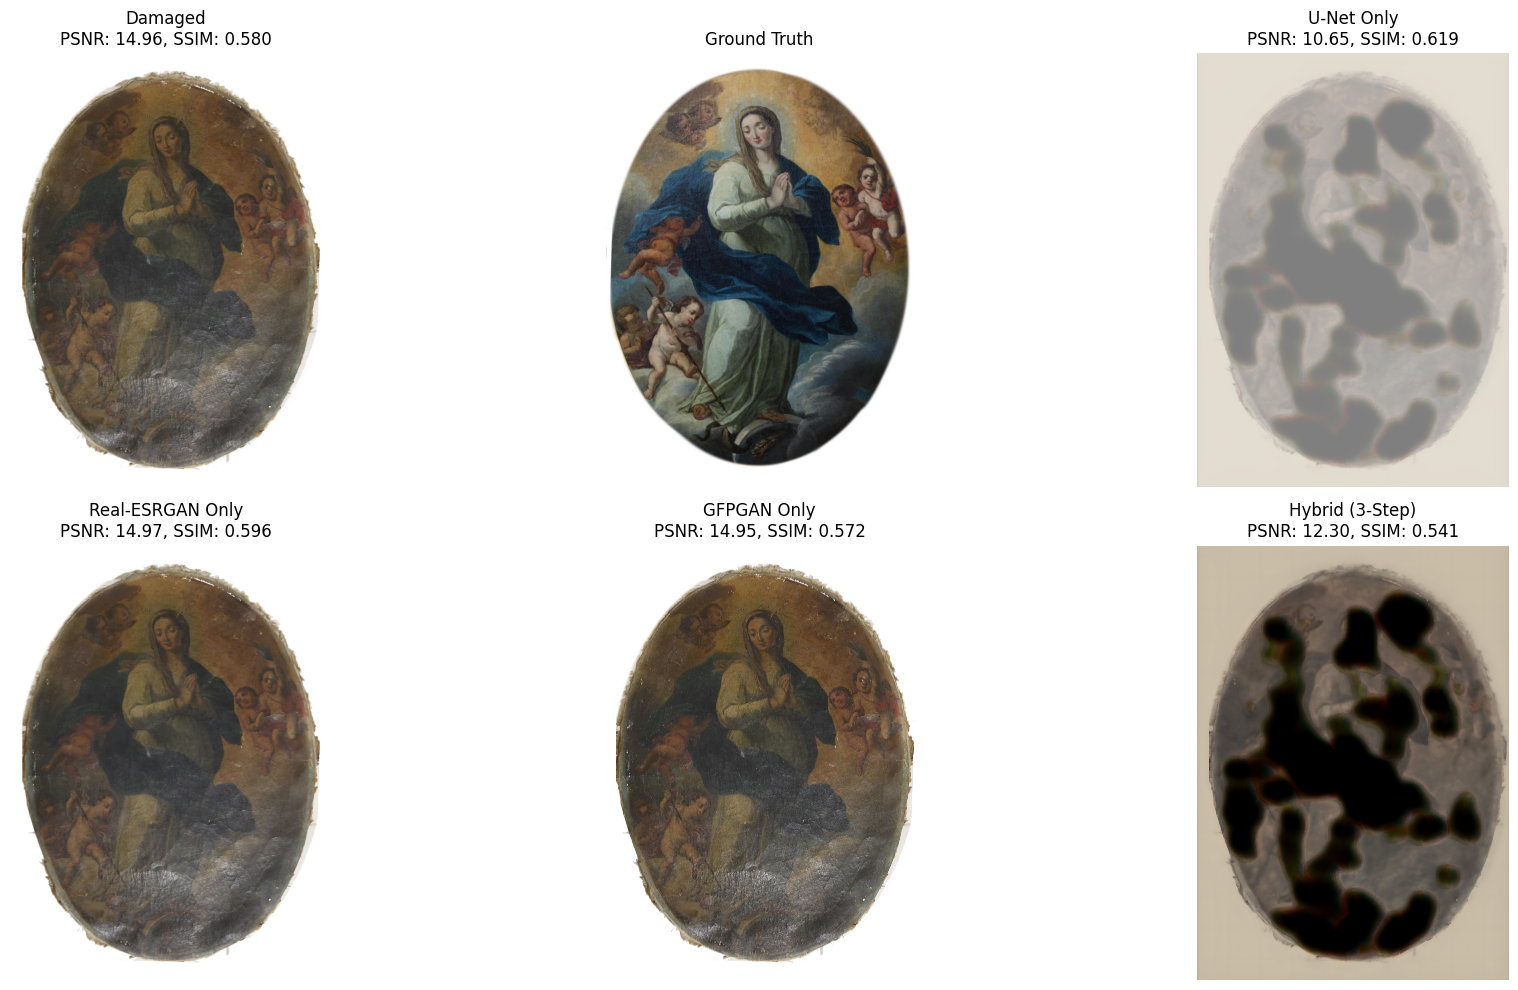

,Image,PSNR_Damaged,SSIM_Damaged,PSNR_U-Net,SSIM_U-Net,PSNR_RealESRGAN,SSIM_RealESRGAN,PSNR_GFPGAN,SSIM_GFPGAN,PSNR_Hybrid,SSIM_Hybrid
0,1.png,14.963176,0.580175,10.646419,0.618755,14.971918,0.595716,14.954485,0.572495,12.303375,0.540745


In [5]:

results_data = []

# Ensure the pipeline loaded before trying to run
if hybrid_pipeline is None:
    print("Evaluation skipped because the Hybrid Pipeline could not be loaded.")
else:
    for img_name in TEST_IMAGES:
        print(f"--- Processing: {img_name} ---")
        # Clear memory before processing each new image
        torch.cuda.empty_cache()
        gc.collect()

        damaged_path = os.path.join(TEST_IMAGE_DIR, img_name)
        truth_path = os.path.join(GROUND_TRUTH_DIR, img_name)

        if not os.path.exists(damaged_path) or not os.path.exists(truth_path):
            print(f"Skipping {img_name}, file not found.")
            continue

        # Load images
        damaged_img_pil = Image.open(damaged_path).convert("RGB")
        ground_truth_img = Image.open(truth_path).convert("RGB")

        # --- Run Restoration ---
        # Convert to BGR format required by OpenCV-based models (Real-ESRGAN, GFPGAN)
        damaged_img_np = np.array(damaged_img_pil)
        damaged_image_bgr = cv2.cvtColor(damaged_img_np, cv2.COLOR_RGB2BGR)
        
        # Run each restoration function
        unet_restored = restore_unet_only(damaged_img_pil)
        print("UNet Restoration done")
    
        realesrgan_restored = restore_realesrgan_only(damaged_image_bgr)
        print("RealESRGAN Restoration done")
        
        gfpgan_restored = restore_gfpgan_only(damaged_image_bgr)
        print("GFPGAN Restoration done")
        
        hybrid_restored = restore_hybrid(damaged_img_pil, img_name) # This is the full 3-step pipeline
        print("Hybrid Restoration done")

        # --- Calculate Metrics ---
        print("Calculating metrics...")
        psnr_damaged, ssim_damaged = calculate_metrics(ground_truth_img, damaged_img_pil)
        psnr_unet, ssim_unet = calculate_metrics(ground_truth_img, unet_restored)
        psnr_realesrgan, ssim_realesrgan = calculate_metrics(ground_truth_img, realesrgan_restored)
        psnr_gfpgan, ssim_gfpgan = calculate_metrics(ground_truth_img, gfpgan_restored)
        psnr_hybrid, ssim_hybrid = calculate_metrics(ground_truth_img, hybrid_restored)

        # --- Store Results ---
        results_data.append({
            "Image": img_name,
            "PSNR_Damaged": psnr_damaged, "SSIM_Damaged": ssim_damaged,
            "PSNR_U-Net": psnr_unet, "SSIM_U-Net": ssim_unet,
            "PSNR_RealESRGAN": psnr_realesrgan, "SSIM_RealESRGAN": ssim_realesrgan,
            "PSNR_GFPGAN": psnr_gfpgan, "SSIM_GFPGAN": ssim_gfpgan,
            "PSNR_Hybrid": psnr_hybrid, "SSIM_Hybrid": ssim_hybrid,
        })

        # --- Display Visuals ---
        images_to_plot = [damaged_img_pil, ground_truth_img, unet_restored, realesrgan_restored, gfpgan_restored, hybrid_restored]
        titles = [
            f"Damaged\nPSNR: {psnr_damaged:.2f}, SSIM: {ssim_damaged:.3f}",
            "Ground Truth",
            f"U-Net Only\nPSNR: {psnr_unet:.2f}, SSIM: {ssim_unet:.3f}",
            f"Real-ESRGAN Only\nPSNR: {psnr_realesrgan:.2f}, SSIM: {ssim_realesrgan:.3f}",
            f"GFPGAN Only\nPSNR: {psnr_gfpgan:.2f}, SSIM: {ssim_gfpgan:.3f}",
            f"Hybrid (3-Step)\nPSNR: {psnr_hybrid:.2f}, SSIM: {ssim_hybrid:.3f}"
        ]
        plot_results(images_to_plot, titles)

# --- Create and display summary DataFrame ---
if results_data:
    df_results = pd.DataFrame(results_data)
    display(df_results)
else:
    print("\nNo results to display. Please ensure the U-Net model is trained and paths are correct.")


### 5. Conclusion

The table and images above provide a comprehensive comparison.

- **Damaged**: The baseline scores for the input images.
- **U-Net Only**: Should show significant improvement in color and lighting, which will be reflected in a higher PSNR/SSIM compared to the damaged version. The image might still appear blurry.
- **Real-ESRGAN Only**: Should produce a sharp image, but the colors might be incorrect or washed out, similar to the damaged input. The PSNR/SSIM might not be high if the colors are wrong.
- **Hybrid**: This should ideally have the best of both worlds: corrected colors from the U-Net and enhanced details from Real-ESRGAN, leading to the highest PSNR and SSIM scores.

Based on the results, we can determine the effectiveness of the hybrid approach.